In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq
import pylab as pl
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree

## 1. Monthly sales and house listings in Denver

    The monthly house sales and listings data in Denver, is from 2016-03 to 2020-09, 55 months in total.

In [2]:
#read the denver listing dates
listData = pd.read_csv('data/denver_listing_dates.csv')
listData['sale_month'] = listData.sale_date.apply(lambda x: str(x)[:-3])
listData['list_month'] = listData.list_date.apply(lambda x: str(x)[:-3])
listMonth = listData.groupby(['list_month']).agg({"property_id":"count"}).reset_index().iloc[:-1,:]
saleMonth = listData.groupby(['sale_month']).agg({"property_id":"count"}).reset_index().iloc[1:-2,:]

In [3]:
monthData = pd.merge(saleMonth,listMonth, left_on='sale_month',right_on='list_month')
monthData = monthData.rename(columns={"sale_month":"month","property_id_x":"count_sale", "property_id_y":"count_list"})
monthData = monthData.drop(['list_month'],axis=1)
monthData.loc[40,'count_list'] = (monthData.loc[39,'count_list']+monthData.loc[41,'count_list'])/2
monthData #month from 2016-03 to 2020-09, 55 months in total

,month,count_sale,count_list
0,2016-03,5259,12926.0
1,2016-04,5571,10692.0
2,2016-05,6340,9405.0
3,2016-06,6941,9635.0
4,2016-07,6476,8318.0
5,2016-08,6686,7864.0
6,2016-09,6218,7148.0
7,2016-10,5719,5559.0
8,2016-11,5421,4179.0
9,2016-12,5317,2939.0


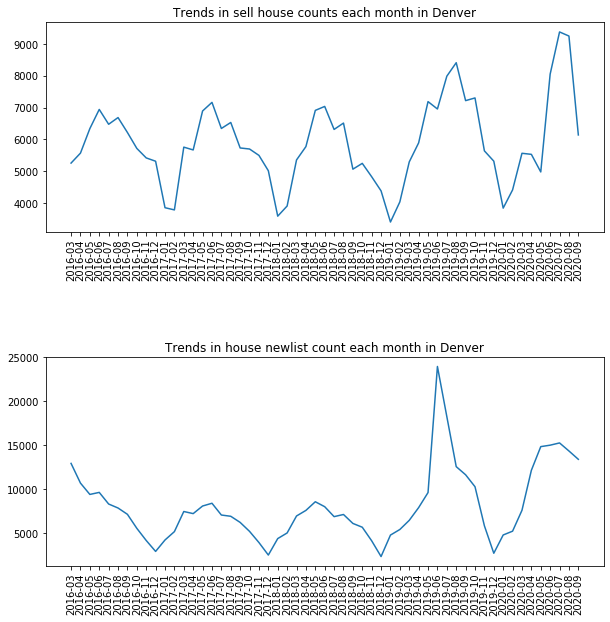

In [4]:
fig,ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(monthData['month'],monthData['count_sale'])
ax[0].set_title('Trends in sell house counts each month in Denver')
ax[0].set_xticklabels(monthData['month'],rotation = 90)
ax[1].plot(monthData['month'],monthData['count_list'])
ax[1].set_title('Trends in house newlist count each month in Denver')
ax[1].set_xticklabels(monthData['month'],rotation = 90)
plt.subplots_adjust(hspace=0.6)

In [82]:
monthData.to_csv('monthData.csv')

## 2. Google Trends data

    We have discussed the google trends keywords to use in Milestone 1. The keywords library is acquired from Rex company with their impressions, i.e., how many ads will be shown by searching these keywords. In general, we will have 3 kinds of keywords sources: keywords for house buyers, keywords for house sellers, and keywords including a particular location "Denver". The keywords are selected according to their impressions. We chose top 20 keywords for buyers with the highest impressions, and top 50 keywords for sellers. It is assumed that keywords with higher impression on the Internet, would have more impact on the house market.
    
    In milestone 2, we will not distinguish the keywords by seller/buyer sides. We will handle those keywords with exactly the same meaning by aggregating them into one predictor. After aggregation of similar key words, we have 28 groups of keywords in final.

In [5]:
Keywords_with_high_imrpessions = [
    ['homes for sale', 'homes for sale in', 'properties for sale','for sale home','homes for sales'], #home for sale
    ['townhomes for sale','townhouses for sale','townhouse for sale'], #townhomes for sale
    'Homes in', 
    'townhouses in',  
    'Homes near me', 
    'condominium for sale near me', 

    'zillow homes for sale',
                
    ['selling a house','sell home', 'selling your home'], #sell homes
     
    ['house appraisal','home appraisal'],#home appraisal
    
    ['home values', 'home valuations', 'home value', 'value of home'],#home values
    ['house valuations','house value', 'house valuation', 'value of house'],#house values
    'property value',
    'real estate values', 
    
    ['home value estimator','estimate property value'],  #home value estimator
     
    ['how much is my house','how much is my house worth',  'price my house', 'how much can i sell my house for'],  #how much is my house
    'home worth',
       
    ['house prices','house price', 'home prices', 'sold home prices'],#home price
                 
    ['rexhomes', 'rex real estate', 'rex home', 'rex house','rex homes'], #rex home
    ['zillow', 'zillow com','zillows'], #zillow.com
    ['real estate agents',  'listing agent'], #agents
    'best realtors',
    ['low commission real estate agents','low commission real estate'],   #low commission real estate
    'how to sell a house without a realtor',
    
                 
    ['for sale by owner', 'fsbo'], #for sale by owner
    'redfin', 
    'trulia', 
    'realtor.com',
    
    ['Homes in Denver', 'townhouses in Denver','houses in Denver'],#homes in denver
    ['selling a house in Denver','sell home in Denver', 'selling your home in Denver','homes for sale in Denver'],#Homes for sale in denver             
    ['house appraisal in Denver', 'home values in Denver', 'house price in Denver'],  #house appraisal in denver                
    'for sale by owner in Denver']

In [6]:
# set up google trends api
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=300)
grouper = pd.Grouper(level='date', freq='M')

In [7]:
def get_keyword_to_time_series(keywords,geo='US-CO'):
    keyword_to_time_series = {}
    for keyword in keywords:
        pytrends = TrendReq(hl='en-US', tz=300)
        if type(keyword) == list:
            pytrends.build_payload(keyword, cat=0, timeframe='2016-03-01 2020-09-30', geo=geo)
            pytrends_df = pytrends.interest_over_time()
            if len(pytrends_df)!=0: 
                pytrends_monthly_df = pytrends_df.groupby(grouper)[keyword].mean().reset_index()
                time_series = np.mean(np.array(pytrends_monthly_df[keyword]),axis=1)
                keyword_to_time_series[keyword[0]] = time_series
                print(keyword)
        else:
            pytrends.build_payload([keyword], cat=0, timeframe='2016-03-01 2020-09-30', geo=geo)
            pytrends_df = pytrends.interest_over_time()
            if len(pytrends_df)!=0: 
                pytrends_monthly_df = pytrends_df.groupby(grouper)[keyword].mean().reset_index()
                time_series = np.array(pytrends_monthly_df[keyword])
                keyword_to_time_series[keyword] = time_series
    return keyword_to_time_series

In [9]:
keyword_to_time_series = get_keyword_to_time_series(Keywords_with_high_imrpessions,geo='US-CO')

['homes for sale', 'homes for sale in', 'properties for sale', 'for sale home', 'homes for sales']
['townhomes for sale', 'townhouses for sale', 'townhouse for sale']
['selling a house', 'sell home', 'selling your home']
['house appraisal', 'home appraisal']
['home values', 'home valuations', 'home value', 'value of home']
['house valuations', 'house value', 'house valuation', 'value of house']
['home value estimator', 'estimate property value']
['how much is my house', 'how much is my house worth', 'price my house', 'how much can i sell my house for']
['house prices', 'house price', 'home prices', 'sold home prices']
['rexhomes', 'rex real estate', 'rex home', 'rex house', 'rex homes']
['zillow', 'zillow com', 'zillows']
['real estate agents', 'listing agent']
['for sale by owner', 'fsbo']
['Homes in Denver', 'townhouses in Denver', 'houses in Denver']
['selling a house in Denver', 'sell home in Denver', 'selling your home in Denver', 'homes for sale in Denver']
['house appraisal in D

In [125]:
trend.to_csv('google_trends.csv')

In [10]:
trend = pd.DataFrame(keyword_to_time_series, index=monthData.month.values).reset_index()
#trend.to_csv('google_trends.csv')
trend

,index,homes for sale,townhomes for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,selling a house,house appraisal,home values,...,real estate agents,best realtors,for sale by owner,redfin,trulia,realtor.com,Homes in Denver,selling a house in Denver,house appraisal in Denver,for sale by owner in Denver
0,2016-03,26.15,29.583333,87.75,45.75,17.50,24.50,31.666667,34.500,21.8125,...,41.375,18.00,42.125,37.25,81.75,52.75,27.916667,16.0625,0.000000,51.25
1,2016-04,26.10,30.583333,94.50,41.50,20.50,23.75,28.833333,42.000,15.7500,...,39.875,37.00,45.250,38.50,77.50,62.25,35.416667,14.0000,4.083333,33.25
2,2016-05,26.92,24.400000,85.20,41.00,22.00,25.00,30.200000,45.000,20.7500,...,23.600,24.40,36.800,42.80,68.00,71.00,30.666667,14.4500,0.000000,46.20
3,2016-06,25.50,27.166667,82.75,43.75,17.00,26.00,32.083333,29.125,20.5000,...,33.000,19.75,41.875,31.50,75.50,57.00,28.833333,12.6875,0.000000,43.25
4,2016-07,26.16,29.266667,85.20,32.80,17.40,26.80,27.600000,40.600,14.6500,...,28.400,16.40,41.200,37.80,75.20,58.80,36.933333,15.7000,3.533333,48.20
5,2016-08,23.60,28.250000,74.50,42.75,19.25,36.00,30.000000,22.250,16.4375,...,32.750,45.25,36.125,35.75,70.00,54.25,27.500000,12.1250,0.000000,53.25
6,2016-09,21.60,27.000000,70.25,51.75,18.50,26.25,26.250000,24.125,17.1250,...,25.125,19.25,36.125,34.00,58.50,50.50,30.666667,13.8750,4.166667,41.00
7,2016-10,20.12,19.933333,68.20,34.80,16.40,16.20,23.800000,39.600,14.5500,...,26.700,22.80,32.300,30.00,51.60,48.00,41.200000,12.1500,0.000000,41.20
8,2016-11,16.90,23.916667,57.25,36.00,15.50,19.75,25.166667,33.750,14.5000,...,20.375,17.50,30.125,30.00,47.00,30.75,25.500000,12.1875,12.333333,44.25
9,2016-12,17.50,21.333333,54.50,40.25,17.50,21.00,22.666667,19.375,12.8750,...,22.375,9.50,27.875,35.25,44.25,36.25,24.000000,6.9375,3.750000,37.50


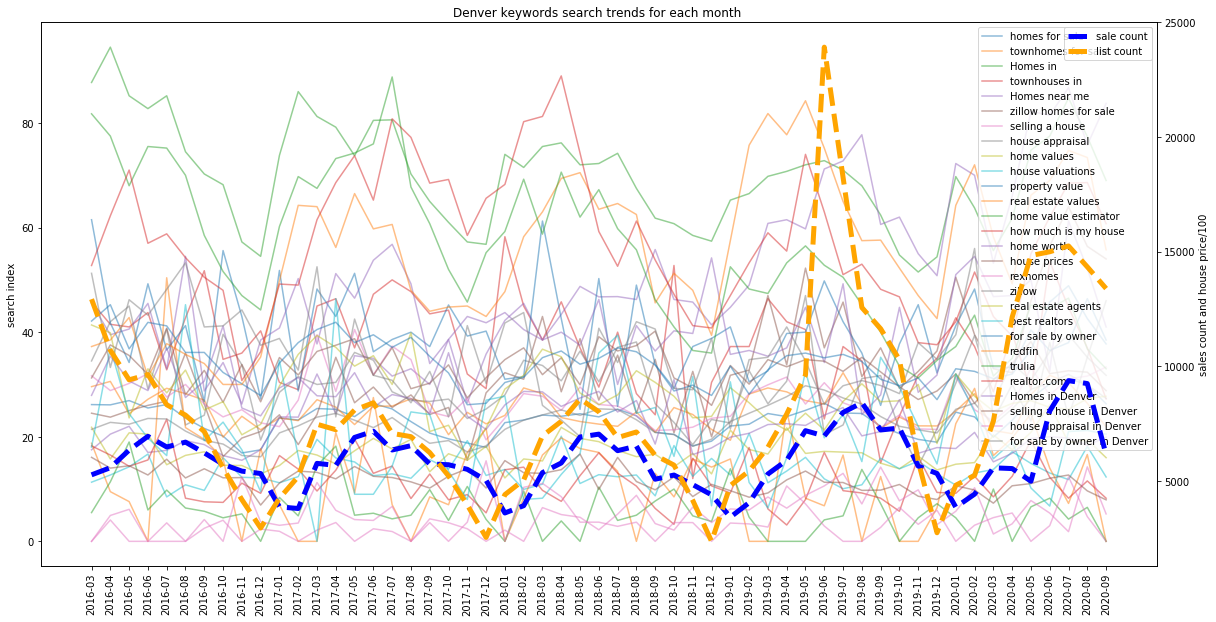

In [11]:
fig, ax1 = plt.subplots(figsize=(20,10))
for keyword, time_series in keyword_to_time_series.items():
    time_series = pd.Series(time_series, index=monthData.month.values)
    ax1.plot(time_series, label=keyword,alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(monthData['month'],monthData['count_sale'],'--',label='sale count',color='blue', linewidth=5)
ax2.plot(monthData['month'],monthData['count_list'],'--',label='list count',color='orange', linewidth=5)
ax2.set_ylabel('sales count and house price/100')
ax1.set_ylabel('search index')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.legend()
plt.title('Denver keywords search trends for each month ')
ax2.legend()
plt.show()

## 3. Predictors and Responses

    There are three kinds of predictors. First, the number of sales and listings in the current month, lag 1 month, and lag 3 month. Second, the google search trends in the current month, lag 1 month, and lag 3 month. Third, the month of a year, using one-hot encoding.
    
    There are two responses. First, the number of house sales in Denver in 3 months. Second, the number of house listings for sale in Denver in 3 months.
    
    In total, there are 102 feature columns and 2 predict targets. The time length is 55 months. We will then treat them as 55 data points.

In [5]:
trend = pd.read_csv('google_trends.csv')
monthData = pd.read_csv('monthData.csv')

In [8]:
merged = pd.merge(monthData, trend, left_on ='month', right_on='index').drop(['index','Unnamed: 0_x','Unnamed: 0_y'],axis=1)
merged

,month,count_sale,count_list,homes for sale,townhomes for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,selling a house,...,real estate agents,best realtors,for sale by owner,redfin,trulia,realtor.com,Homes in Denver,selling a house in Denver,house appraisal in Denver,for sale by owner in Denver
0,2016-03,5259,12926.0,26.15,29.583333,87.75,45.75,17.50,24.50,31.666667,...,41.375,18.00,42.125,37.25,81.75,52.75,27.916667,16.0625,0.000000,51.25
1,2016-04,5571,10692.0,26.10,30.583333,94.50,41.50,20.50,23.75,28.833333,...,39.875,37.00,45.250,38.50,77.50,62.25,35.416667,14.0000,4.083333,33.25
2,2016-05,6340,9405.0,26.92,24.400000,85.20,41.00,22.00,25.00,30.200000,...,23.600,24.40,36.800,42.80,68.00,71.00,30.666667,14.4500,0.000000,46.20
3,2016-06,6941,9635.0,25.50,27.166667,82.75,43.75,17.00,26.00,32.083333,...,33.000,19.75,41.875,31.50,75.50,57.00,28.833333,12.6875,0.000000,43.25
4,2016-07,6476,8318.0,26.16,29.266667,85.20,32.80,17.40,26.80,27.600000,...,28.400,16.40,41.200,37.80,75.20,58.80,36.933333,15.7000,3.533333,48.20
5,2016-08,6686,7864.0,23.60,28.250000,74.50,42.75,19.25,36.00,30.000000,...,32.750,45.25,36.125,35.75,70.00,54.25,27.500000,12.1250,0.000000,53.25
6,2016-09,6218,7148.0,21.60,27.000000,70.25,51.75,18.50,26.25,26.250000,...,25.125,19.25,36.125,34.00,58.50,50.50,30.666667,13.8750,4.166667,41.00
7,2016-10,5719,5559.0,20.12,19.933333,68.20,34.80,16.40,16.20,23.800000,...,26.700,22.80,32.300,30.00,51.60,48.00,41.200000,12.1500,0.000000,41.20
8,2016-11,5421,4179.0,16.90,23.916667,57.25,36.00,15.50,19.75,25.166667,...,20.375,17.50,30.125,30.00,47.00,30.75,25.500000,12.1875,12.333333,44.25
9,2016-12,5317,2939.0,17.50,21.333333,54.50,40.25,17.50,21.00,22.666667,...,22.375,9.50,27.875,35.25,44.25,36.25,24.000000,6.9375,3.750000,37.50


In [9]:
merged.columns

Index(['month', 'count_sale', 'count_list', 'homes for sale',
       'townhomes for sale', 'Homes in', 'townhouses in', 'Homes near me',
       'zillow homes for sale', 'selling a house', 'house appraisal',
       'home values', 'house valuations', 'property value',
       'real estate values', 'home value estimator', 'how much is my house',
       'home worth', 'house prices', 'rexhomes', 'zillow',
       'real estate agents', 'best realtors', 'for sale by owner', 'redfin',
       'trulia', 'realtor.com', 'Homes in Denver', 'selling a house in Denver',
       'house appraisal in Denver', 'for sale by owner in Denver'],
      dtype='object')

In [10]:
#predictors: current, lag1, lag3 for google trends, current, lag1, lag3 of count of sales/listings, month of a year t
feature_column_names = merged.columns[1:]
f = feature_column_names.copy()
for i, col in enumerate(f):
    merged[str(col)+'_lag1'] = merged[col].diff(1)
    merged[str(col)+'_lag3'] = merged[col].diff(3)
    feature_column_names = np.append(feature_column_names,str(col)+'_lag1')
    feature_column_names = np.append(feature_column_names,str(col)+'_lag3')
    



In [11]:
merged['t'] = merged['month'].apply(lambda x: str(x[-2:])+'m')
one_hot_month = pd.get_dummies(merged['t'])
feature_column_names = np.append(feature_column_names,one_hot_month.columns)
merged = merged.join(one_hot_month)

In [12]:
#predict number of sales and listings in 3 months
merged['count_sale_target'] = merged['count_sale'].shift(-3)
merged['count_list_target'] = merged['count_list'].shift(-3)

In [13]:
merged

,month,count_sale,count_list,homes for sale,townhomes for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,selling a house,...,05m,06m,07m,08m,09m,10m,11m,12m,count_sale_target,count_list_target
0,2016-03,5259,12926.0,26.15,29.583333,87.75,45.75,17.50,24.50,31.666667,...,0,0,0,0,0,0,0,0,6941.0,9635.0
1,2016-04,5571,10692.0,26.10,30.583333,94.50,41.50,20.50,23.75,28.833333,...,0,0,0,0,0,0,0,0,6476.0,8318.0
2,2016-05,6340,9405.0,26.92,24.400000,85.20,41.00,22.00,25.00,30.200000,...,1,0,0,0,0,0,0,0,6686.0,7864.0
3,2016-06,6941,9635.0,25.50,27.166667,82.75,43.75,17.00,26.00,32.083333,...,0,1,0,0,0,0,0,0,6218.0,7148.0
4,2016-07,6476,8318.0,26.16,29.266667,85.20,32.80,17.40,26.80,27.600000,...,0,0,1,0,0,0,0,0,5719.0,5559.0
5,2016-08,6686,7864.0,23.60,28.250000,74.50,42.75,19.25,36.00,30.000000,...,0,0,0,1,0,0,0,0,5421.0,4179.0
6,2016-09,6218,7148.0,21.60,27.000000,70.25,51.75,18.50,26.25,26.250000,...,0,0,0,0,1,0,0,0,5317.0,2939.0
7,2016-10,5719,5559.0,20.12,19.933333,68.20,34.80,16.40,16.20,23.800000,...,0,0,0,0,0,1,0,0,3860.0,4236.0
8,2016-11,5421,4179.0,16.90,23.916667,57.25,36.00,15.50,19.75,25.166667,...,0,0,0,0,0,0,1,0,3791.0,5184.0
9,2016-12,5317,2939.0,17.50,21.333333,54.50,40.25,17.50,21.00,22.666667,...,0,0,0,0,0,0,0,1,5759.0,7468.0


In [14]:
len(feature_column_names)

102

In [15]:
target_column_names = ['count_sale_target', 'count_list_target']

## 4. Data cleaning,  train-test split, normalization, dimension reduction

    There are 49 data samples. We will use the first 80% data as the training set, and last 20% data as the test set. We have three ways to reduce the dimension. Lasso regression, PCA, and feature importance in random forest.

In [44]:
merged = merged.dropna(axis=0)
train_X, test_X, train_y, test_y = train_test_split(merged[feature_column_names],merged[target_column_names], test_size = 0.2, random_state=100, shuffle=False)
#standardize the features
std = StandardScaler()
std.fit(train_X)
train_X_std =std.transform(train_X)
test_X_std = std.transform(test_X)

### Dimension reduction: Lasso, PCA, feature_importance in random forest

In [45]:
#lasso for sales
lr = LassoCV()
lr.fit(train_X_std, train_y['count_sale_target'])
selected_features_sale = feature_column_names[abs(lr.coef_)>0]
selected_features_sale_no = abs(lr.coef_)>0
selected_features_sale

array(['townhomes for sale', 'zillow homes for sale',
       'home value estimator', 'house prices', 'zillow',
       'count_sale_lag3', 'count_list_lag3', 'Homes near me_lag3',
       'home value estimator_lag3', 'zillow_lag3', 'realtor.com_lag3',
       '05m', '10m', '11m', '12m'], dtype=object)

In [46]:
#lasso for listings
lr = LassoCV()
lr.fit(train_X_std, train_y['count_list_target'])
selected_features_list = feature_column_names[abs(lr.coef_)>0]
selected_features_list_no = abs(lr.coef_)>0
selected_features_list

array(['Homes near me', 'home value estimator', 'how much is my house',
       'zillow', 'real estate agents', 'trulia', 'realtor.com',
       'selling a house in Denver', 'count_sale_lag3', 'count_list_lag1',
       'townhomes for sale_lag3', 'townhouses in_lag3',
       'Homes near me_lag3', 'zillow homes for sale_lag3',
       'house valuations_lag1', 'how much is my house_lag1',
       'for sale by owner_lag1', 'redfin_lag3', 'realtor.com_lag3', '03m',
       '09m'], dtype=object)

Text(0.5, 1.0, 'Top 4 components explained over 99% variances in PCA')

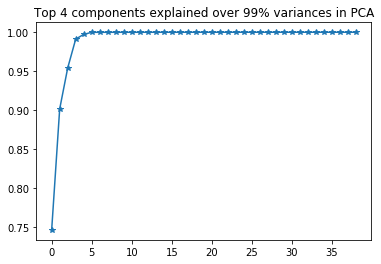

In [47]:
#pca
pca = PCA()
train_X_pca = pca.fit_transform(train_X)
plt.plot(pca.explained_variance_ratio_.cumsum(),'*-')
plt.title('Top 4 components explained over 99% variances in PCA')
# From pca, the first 4 variables explained over 99% variances

In [48]:
train_X_pca = pca.transform(train_X)[:,:4]
test_X_pca = pca.transform(test_X)[:,:4]

In [49]:
#random forest for sales
#use grid search to find the params
params = {'max_depth':[1,2,3,4], 'min_samples_leaf':[1,2,3,5,], 
          'n_estimators':[5,10,20,], 'min_samples_split':[4,6,8,10,15]}
scores_cv = []

model = RandomForestRegressor()
clf = GridSearchCV(model, params,cv=4,scoring='neg_mean_squared_error')
clf.fit(train_X_std, train_y['count_sale_target'])
clf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [53]:
model = RandomForestRegressor(n_estimators=5, max_depth=2, min_samples_leaf=1,min_samples_split=10)
model.fit(train_X_std, train_y['count_sale_target'])


y_pred_train = model.predict(train_X_std)
y_pred_test = model.predict(test_X_std)


rf_rst = {'r2_train': model.score(train_X_std, train_y['count_sale_target']),
             'r2_test':model.score(test_X_std, test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
             'cv_score':-cross_val_score(model, train_X_std, train_y['count_sale_target'], cv=3,scoring='neg_mean_squared_error').mean()}
rf_rst

{'r2_train': 0.8786323043913412,
 'r2_test': 0.20273806802095506,
 'mse_train': 177412.0414989546,
 'mse_test': 2752206.1102710213,
 'cv_score': 795378.7601605266}

array([0.29700508, 0.45588052, 0.61314317, 0.73628433, 0.83891226,
       0.92277418, 0.9537308 , 0.98391609, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

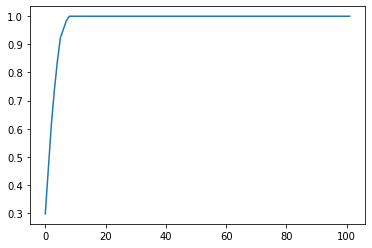

In [54]:
plt.plot(-np.sort(-model.feature_importances_).cumsum())
-np.sort(-model.feature_importances_).cumsum()[:20]
#From random forst, the first 10 features are mostly important and account for 93% of feature importance

In [55]:
selected_features_sale_no_rf = np.argsort(-model.feature_importances_)[:7]
selected_features_sale_rf = feature_column_names[selected_features_sale_no_rf]
selected_features_sale_rf

array(['Homes in_lag3', 'redfin', 'count_sale_lag1', 'count_list_lag3',
       'trulia_lag3', 'zillow_lag3', 'count_sale_lag3'], dtype=object)

In [57]:
#random forest for listings
#use grid search to find the params
params = {'max_depth':[1,2,3,4], 'min_samples_leaf':[1,2,3,5], 
          'n_estimators':[5,10,20,30], 'min_samples_split':[4,6,8,10,15]}
scores_cv = []

model = RandomForestRegressor()
clf = GridSearchCV(model, params,cv=4,scoring='neg_mean_squared_error')
clf.fit(train_X_std, train_y['count_list_target'])
clf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
model = RandomForestRegressor(n_estimators=5, max_depth=3, min_samples_leaf=2,min_samples_split=8)
model.fit(train_X_std, train_y['count_list_target'])

y_pred_train = model.predict(train_X_std)
y_pred_test = model.predict(test_X_std)


rf_rst = {'r2_train': model.score(train_X_std, train_y['count_list_target']),
             'r2_test':model.score(test_X_std, test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
             'cv_score':-cross_val_score(model, train_X_std, train_y['count_list_target'], cv=3,scoring='neg_mean_squared_error').mean()}
rf_rst

{'r2_train': 0.5366712539677727,
 'r2_test': -0.1057199894697447,
 'mse_train': 7262347.692224479,
 'mse_test': 23894523.3454852,
 'cv_score': 16090663.607095366}

array([0.45585247, 0.59729168, 0.71774799, 0.80056673, 0.87553163,
       0.9092699 , 0.92739696, 0.94162852, 0.95360964, 0.96287795,
       0.97127473, 0.97952706, 0.98687611, 0.99349461, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

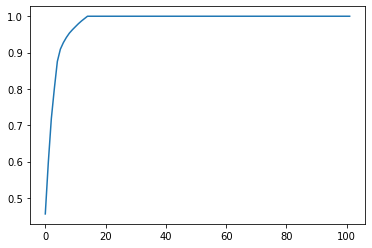

In [59]:
plt.plot(-np.sort(-model.feature_importances_).cumsum())
-np.sort(-model.feature_importances_).cumsum()[:20]
#From random forst, the first 5 features are mostly important and account for 91% of feature importance

In [60]:
selected_features_list_no_rf = np.argsort(-model.feature_importances_)[:10]
selected_features_list_rf = feature_column_names[selected_features_list_no_rf]
selected_features_list_rf

array(['zillow', 'zillow_lag3', 'rexhomes', 'homes for sale_lag1',
       'zillow_lag1', 'Homes near me', 'how much is my house_lag1',
       'house appraisal in Denver', 'redfin_lag3', 'house prices'],
      dtype=object)

## 5. Build Models - the number of sales
### 5.1 Linear models

In [61]:
#lasso 
model = LassoCV()
model.fit(train_X_std, train_y['count_sale_target'])
y_pred_train = model.predict(train_X_std)
y_pred_test = model.predict(test_X_std)

lasso_rst = {'r2_train': model.score(train_X_std, train_y['count_sale_target']),
             'r2_test':model.score(test_X_std, test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std, train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
lasso_rst

{'r2_train': 0.9161179117294777,
 'r2_test': 0.15387210354582925,
 'mse_train': 122616.5863217327,
 'mse_test': 2920894.9697514744,
 'cv_score': 698037.2196205964}

In [62]:
#elastic
model = sklearn.linear_model.ElasticNetCV()
model.fit(train_X_std, train_y['count_sale_target'])
y_pred_train = model.predict(train_X_std)
y_pred_test = model.predict(test_X_std)

elastic_rst = {'r2_train': model.score(train_X_std, train_y['count_sale_target']),
             'r2_test':model.score(test_X_std, test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std, train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
elastic_rst

{'r2_train': 0.9279561494556265,
 'r2_test': 0.0055109354217730555,
 'mse_train': 105311.76799908695,
 'mse_test': 3433048.500554581,
 'cv_score': 709038.8983830654}

In [63]:
#ridge after lasso
model = sklearn.linear_model.RidgeCV()
model.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no])

ridge_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
ridge_rst

{'r2_train': 0.9422258373794135,
 'r2_test': 0.07619948796483278,
 'mse_train': 84452.7210062608,
 'mse_test': 3189026.4816525965,
 'cv_score': 281295.6457475756}

In [64]:
#ridge after rf
model = sklearn.linear_model.RidgeCV()
model.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_sale_no_rf])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no_rf])

ridge1_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no_rf], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
ridge1_rst

{'r2_train': 0.8054952212332002,
 'r2_test': 0.14844553840638786,
 'mse_train': 284321.8676046001,
 'mse_test': 2939627.8668527836,
 'cv_score': 581538.1470280372}

In [65]:
#ridge after pca
model = sklearn.linear_model.RidgeCV()
model.fit(train_X_pca, train_y['count_sale_target'])
y_pred_train = model.predict(train_X_pca)
y_pred_test = model.predict(test_X_pca)

pcalr_rst = {'r2_train': model.score(train_X_pca, train_y['count_sale_target']),
             'r2_test':model.score(test_X_pca, test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_pca, train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
pcalr_rst

{'r2_train': 0.5718931015482818,
 'r2_test': -0.1029085927707658,
 'mse_train': 625795.1792955222,
 'mse_test': 3807320.588553949,
 'cv_score': 2317933.482440356}

ridge_rst


### 5.2 KNN

Text(0, 0.5, 'score')

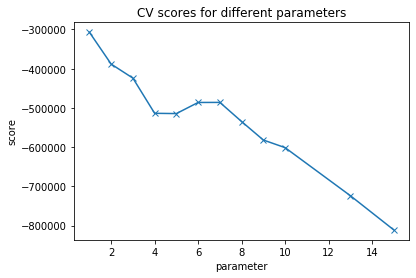

In [58]:
#using cross validation to find n_neighbors
neighbors = [1,2,3,4,5,6,7,8,9,10,13,15]
scores_cv = []
for n in neighbors:
    model = KNeighborsRegressor(n_neighbors=n)
    scores_cv.append(cross_val_score(model, train_X_std[:,selected_features_sale_no], train_y['count_sale_target'], cv=4, 
                                     scoring='neg_mean_squared_error').mean())

plt.plot(neighbors,scores_cv,'x-')
plt.title('CV scores for different parameters')
plt.xlabel('parameter')
plt.ylabel('score')

In [66]:
model = KNeighborsRegressor(n_neighbors=2)
model.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no])

knn_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
knn_rst

{'r2_train': 0.9206928895956752,
 'r2_test': 0.3134957849163459,
 'mse_train': 115929.0064102564,
 'mse_test': 2369862.425,
 'cv_score': 384981.7607142857}

In [67]:
model = KNeighborsRegressor(n_neighbors=2)
model.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_sale_no_rf])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no_rf])

knn1_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no_rf], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
knn1_rst

{'r2_train': 0.9418069681419708,
 'r2_test': 0.314226585005388,
 'mse_train': 85065.01282051283,
 'mse_test': 2367339.65,
 'cv_score': 491827.88482142857}

In [73]:
model = KNeighborsRegressor(n_neighbors=2)
model.fit(train_X_pca, train_y['count_sale_target'])
y_pred_train = model.predict(train_X_pca)
y_pred_test = model.predict(test_X_pca)

knn2_rst = {'r2_train': model.score(train_X_pca, train_y['count_sale_target']),
             'r2_test':model.score(test_X_pca, test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_pca, train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
knn2_rst

{'r2_train': 0.9290965575777467,
 'r2_test': 0.6025810392489857,
 'mse_train': 103644.75,
 'mse_test': 1371919.125,
 'cv_score': 363955.86160714284}

KNN model after PCA performs better. knn2_rst

### 5.3 Tree

In [42]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []
model = DecisionTreeRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_target'])
clf.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [74]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=2)
model.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no])

tree_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
tree_rst

{'r2_train': 0.9691946738431024,
 'r2_test': 0.2496751267173908,
 'mse_train': 45030.39935897436,
 'mse_test': 2590175.973673611,
 'cv_score': 547393.0417896826}

In [80]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []
model = DecisionTreeRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'])
clf.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [75]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=2)
model.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_sale_no_rf])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no_rf])

tree1_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no_rf], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
tree1_rst

{'r2_train': 0.8928405056150635,
 'r2_test': 0.2766568068735299,
 'mse_train': 156642.87411477408,
 'mse_test': 2497033.2535555554,
 'cv_score': 551607.8949438775}

In [83]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []
model = DecisionTreeRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_pca, train_y['count_sale_target'])
clf.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [76]:
model = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=6)
model.fit(train_X_pca, train_y['count_sale_target'])
y_pred_train = model.predict(train_X_pca)
y_pred_test = model.predict(test_X_pca)

tree2_rst = {'r2_train': model.score(train_X_pca, train_y['count_sale_target']),
             'r2_test':model.score(test_X_pca, test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_pca, train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
tree2_rst

{'r2_train': 0.9124133234940427,
 'r2_test': -0.03236361273152899,
 'mse_train': 128031.85402097902,
 'mse_test': 3563794.192365703,
 'cv_score': 570908.8626612773}

Tree model with features selected by random forest performs better. tree_rst

### 5.4 Bagging: Random Forest

In [89]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,3,5,7], 
          'n_estimators':[5,10,20], 'min_samples_split':[2,4,6,8,10,15]}
scores_cv = []

model = RandomForestRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'])
clf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [77]:
model = RandomForestRegressor(n_estimators=5, max_depth=5, min_samples_leaf=1,min_samples_split=10)

y_pred_train = []
y_pred_test = []
for i in range(500):
    model.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_sale_no_rf]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_sale_no_rf]))
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)

rf_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no_rf], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
rf_rst

{'r2_train': 0.8787997661174427,
 'r2_test': 0.3674389928676425,
 'mse_train': 128748.47789562191,
 'mse_test': 2353013.9625071413,
 'cv_score': 440494.9741323812}

In [91]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4], 'min_samples_leaf':[1,3,5,7], 
          'n_estimators':[5,10,20], 'min_samples_split':[2,4,6,8,10,15]}
scores_cv = []

model = RandomForestRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_target'])
clf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [78]:
model = RandomForestRegressor(n_estimators=20, max_depth=3, min_samples_leaf=1,min_samples_split=4)
y_pred_train = []
y_pred_test = []
for i in range(500):
    model.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_sale_no]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_sale_no]))
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)

rf1_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
rf1_rst

{'r2_train': 0.9458399283516261,
 'r2_test': 0.38539795328758364,
 'mse_train': 76925.1750005854,
 'mse_test': 2262083.313587445,
 'cv_score': 455069.72621962393}

In [80]:
model = RandomForestRegressor(n_estimators=5, max_depth=3, min_samples_leaf=1,min_samples_split=4)
y_pred_train = []
y_pred_test = []
for i in range(500):
    model.fit(train_X_pca, train_y['count_sale_target'])
    y_pred_train.append(model.predict(train_X_pca))
    y_pred_test.append(model.predict(test_X_pca))
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)

rf2_rst = {'r2_train': model.score(train_X_pca, train_y['count_sale_target']),
             'r2_test':model.score(test_X_pca, test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_pca, train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
rf2_rst

{'r2_train': 0.83535288082426,
 'r2_test': -0.02632835838828962,
 'mse_train': 130434.97883594404,
 'mse_test': 2405832.430704511,
 'cv_score': 694725.898945895}

Random forest with features selected by lasso, performs better. rf_rst

### 5.5 Boosting: GBDT

In [93]:
#use grid search to find the params
params = {'learning_rate':[0.1,0.3,0.5,1.],'max_depth':[2,3,4], 'min_samples_leaf':[4,6,8], 
          'min_samples_split':[5,10,15],'n_estimators':[5,10,20], 'subsample':[0.3,0.5,0.8,1.]}
scores_cv = []

model = GradientBoostingRegressor()
clf = GridSearchCV(model, params,cv=5, scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'])
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
model = GradientBoostingRegressor(learning_rate=0.3, n_estimators=10, subsample=0.8, 
                                  max_depth=4,min_samples_split=5, min_samples_leaf=4)
y_pred_train = []
y_pred_test = []
for i in range(1000):
    model.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_sale_no_rf]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_sale_no_rf]))
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)

gbdt_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no_rf], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
gbdt_rst

{'r2_train': 0.9662653858904389,
 'r2_test': 0.36471056297212445,
 'mse_train': 33515.45164081455,
 'mse_test': 2526596.7898850963,
 'cv_score': 539829.6299384625}

In [96]:
#use grid search to find the params
params = {'learning_rate':[0.1,0.3,0.5,1.],'max_depth':[2,3,4], 'min_samples_leaf':[4,6,8], 
          'min_samples_split':[5,10,15],'n_estimators':[5,10,20], 'subsample':[0.3,0.5,0.8,1.]}
scores_cv = []

model = GradientBoostingRegressor()
clf = GridSearchCV(model, params,cv= 5, scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_target'])
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [84]:
model = GradientBoostingRegressor(learning_rate=0.3, n_estimators=10, subsample=0.5, 
                                  max_depth=4,min_samples_split=5, min_samples_leaf=4)

y_pred_train = []
y_pred_test = []
for i in range(1000):
    model.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_sale_no]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_sale_no]))
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)


gbdt1_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_target']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_target']),
             'mse_train': mean_squared_error(train_y['count_sale_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_sale_no], train_y['count_sale_target'], cv=5,scoring='neg_mean_squared_error').mean()}
gbdt1_rst

{'r2_train': 0.9407569435266132,
 'r2_test': 0.3847804333410908,
 'mse_train': 75422.84733452485,
 'mse_test': 2538771.3517962852,
 'cv_score': 577713.6419601556}

GBDT with features selected by random forest performs better. gbdt_rst

### 5.6 Comparison: models to predict the number of house sales in 3 months in Denver

In [87]:
result = pd.DataFrame(columns=['Lasso','Elastic','Ridge after Lasso','Regression after PCA','KNN', 'Tree','RandomForest','GBDT'])
for i,mod in enumerate([lasso_rst, elastic_rst,ridge_rst,pcalr_rst, knn2_rst,tree_rst,rf_rst,gbdt_rst]):
    result.iloc[:,i] = pd.Series(mod)
result

,Lasso,Elastic,Ridge after Lasso,Regression after PCA,KNN,Tree,RandomForest,GBDT
r2_train,9.161179e-01,9.279561e-01,9.422258e-01,5.718931e-01,9.290966e-01,9.691947e-01,8.787998e-01,9.662654e-01
r2_test,1.538721e-01,5.510935e-03,7.619949e-02,-1.029086e-01,6.025810e-01,2.496751e-01,3.674390e-01,3.647106e-01
mse_train,1.226166e+05,1.053118e+05,8.445272e+04,6.257952e+05,1.036448e+05,4.503040e+04,1.287485e+05,3.351545e+04
mse_test,2.920895e+06,3.433049e+06,3.189026e+06,3.807321e+06,1.371919e+06,2.590176e+06,2.353014e+06,2.526597e+06
cv_score,6.980372e+05,7.090389e+05,2.812956e+05,2.317933e+06,3.639559e+05,5.473930e+05,4.404950e+05,5.398296e+05


Text(0.5, 1.0, 'cross validation MSE for predicting sales')

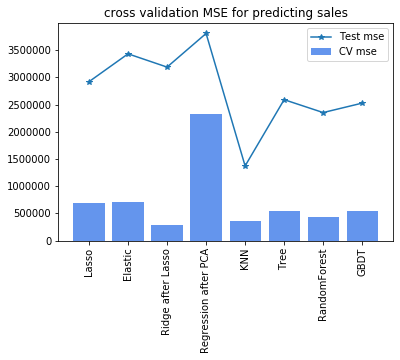

In [92]:
plt.bar(result.columns, result.loc['cv_score',:],color='cornflowerblue',label='CV mse')
plt.plot(result.columns, result.loc['mse_test',:],'*-',label='Test mse')
plt.legend()
plt.xticks(rotation = 90)
plt.title('cross validation MSE for predicting sales')

     The model that performs best in all data set with cross validation is Ridge regression with features selected by Lasso. The results of Random Forest and GBDT is very sensitive because of the randomness and the data set is too small, thus we do not prefer using them here. Therefore, Ridge regression will be better in this case. 

In [195]:
#knn after pca
model = KNeighborsRegressor(n_neighbors=2)
y_predict = []
for i in range(1000):
    indices = np.random.choice(np.arange(39),39, replace=True)
    model.fit(train_X_pca[indices,:], train_y['count_sale_target'].values[indices])
    predict = np.append(model.predict(train_X_pca),model.predict(test_X_pca))
    y_predict.append(predict)
    #plt.plot(monthData.month[3:52], np.append(model.predict(train_X_pca),model.predict(test_X_pca)),alpha=0.03,color='pink')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text xticklabel objects>)

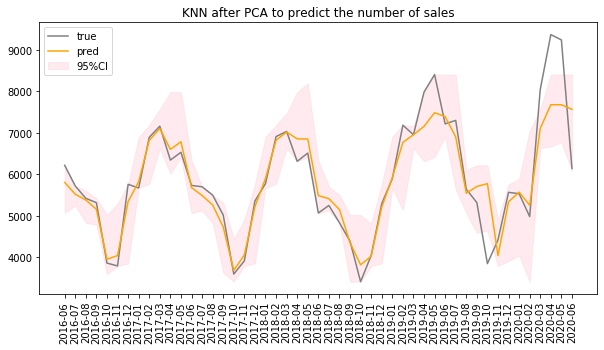

In [196]:
plt.figure(figsize=(10,5))
y_predict_mean = np.mean(np.array(y_predict),axis=0)
y_pred_upper = np.percentile(np.array(y_predict),97.5, axis=0)
y_pred_lower = np.percentile(np.array(y_predict),2.5, axis=0)

plt.plot(monthData.month[3:52], merged['count_sale_target'], label='true',color='grey')
plt.plot(monthData.month[3:52], y_predict_mean, label='pred',color='orange')
plt.fill_between(monthData.month[3:52], y_pred_upper, y_pred_lower, color = 'pink',alpha=0.3,label='95%CI')
plt.legend()
plt.title('KNN after PCA to predict the number of sales')
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text xticklabel objects>)

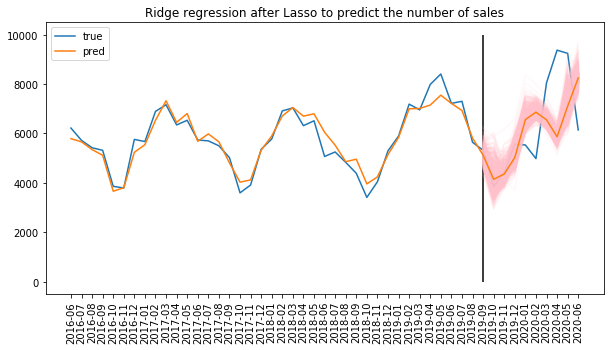

In [573]:
#ridge after lasso -- plot
model = sklearn.linear_model.RidgeCV()
y_pred_train = []
y_pred_test = []
plt.figure(figsize=(10,5))
plt.plot(monthData.month[3:52], merged['count_sale_target'], label='true')
for i in range(1000):
    indices = np.random.choice(np.arange(39),39, replace=True)
    model.fit(train_X_std[indices,:][:,selected_features_sale_no], train_y['count_sale_target'].values[indices])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_sale_no]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_sale_no]))
    plt.plot(monthData.month[42:52], model.predict(test_X_std[:,selected_features_sale_no]),alpha=0.1,color='pink')
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)
plt.plot(monthData.month[3:52], np.append(y_pred_train, y_pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)
plt.title('Ridge regression after Lasso to predict the number of sales')
plt.xticks(rotation=90)



## 6. Build Models - the number of listings
### 6.1 Linear models

In [93]:
#lasso 
model = LassoCV()
model.fit(train_X_std, train_y['count_list_target'])
y_pred_train = model.predict(train_X_std)
y_pred_test = model.predict(test_X_std)

lasso_rst = {'r2_train': model.score(train_X_std, train_y['count_list_target']),
             'r2_test':model.score(test_X_std, test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std, train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
lasso_rst

{'r2_train': 0.9094962034023147,
 'r2_test': 0.43866172880000376,
 'mse_train': 1418582.473000791,
 'mse_test': 12130476.570596196,
 'cv_score': 17368941.97162842}

In [94]:
#elastic
model = sklearn.linear_model.ElasticNetCV()
model.fit(train_X_std, train_y['count_list_target'])
y_pred_train = model.predict(train_X_std)
y_pred_test = model.predict(test_X_std)

elastic_rst = {'r2_train': model.score(train_X_std, train_y['count_list_target']),
             'r2_test':model.score(test_X_std, test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std, train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
elastic_rst

{'r2_train': 0.7453712350382562,
 'r2_test': 0.40798601313066507,
 'mse_train': 3991124.31384792,
 'mse_test': 12793376.410683183,
 'cv_score': 16508540.07900248}

In [95]:
#ridge after lasso
model = sklearn.linear_model.RidgeCV()
model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_list_no])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no])

ridge_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
ridge_rst

{'r2_train': 0.9611760081283526,
 'r2_test': 0.45942583293906425,
 'mse_train': 608538.3870233449,
 'mse_test': 11681765.888123324,
 'cv_score': 7489097.9290498365}

In [96]:
#ridge after rf
model = sklearn.linear_model.RidgeCV(cv=4)
model.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_list_no_rf])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no_rf])

ridge1_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no_rf], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
ridge1_rst

{'r2_train': 0.6642899255500104,
 'r2_test': 0.3262145042644921,
 'mse_train': 5262016.0206265515,
 'mse_test': 14560452.384895533,
 'cv_score': 16894767.065159094}

In [97]:
#ridge after pca
model = sklearn.linear_model.RidgeCV()
model.fit(train_X_pca, train_y['count_list_target'])
y_pred_train = model.predict(train_X_pca)
y_pred_test = model.predict(test_X_pca)

pcalr_rst = {'r2_train': model.score(train_X_pca, train_y['count_list_target']),
             'r2_test':model.score(test_X_pca, test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_pca, train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
pcalr_rst

{'r2_train': 0.45398250043000327,
 'r2_test': -1.4035608642297404,
 'mse_train': 8558434.938203752,
 'mse_test': 51940764.14425136,
 'cv_score': 28440299.144856147}

For linear models, Ridge regression with cross validation performs the best. ridge_rst

### 6.2 KNN

Text(0, 0.5, 'score')

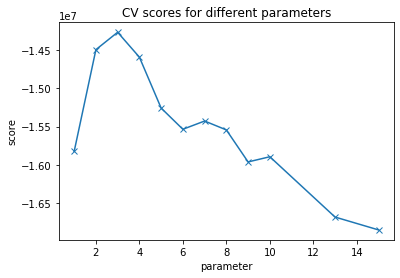

In [98]:
#using cross validation to find n_neighbors
neighbors = [1,2,3,4,5,6,7,8,9,10,13,15]
scores_cv = []
for n in neighbors:
    model = KNeighborsRegressor(n_neighbors=n)
    scores_cv.append(cross_val_score(model, train_X_std[:,selected_features_list_no], train_y['count_list_target'], cv=4, 
                                     scoring='neg_mean_squared_error').mean())

plt.plot(neighbors,scores_cv,'x-')
plt.title('CV scores for different parameters')
plt.xlabel('parameter')
plt.ylabel('score')

In [99]:
#knn after lasso
model = KNeighborsRegressor(n_neighbors=3)
model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_list_no])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no])

knn_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
knn_rst

{'r2_train': 0.8277218000644437,
 'r2_test': -0.014169307087461114,
 'mse_train': 2700337.931623931,
 'mse_test': 21916120.188888896,
 'cv_score': 14421524.097619051}

Text(0, 0.5, 'score')

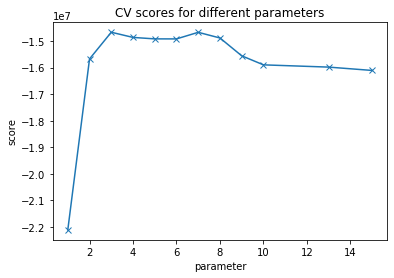

In [100]:
#using cross validation to find n_neighbors
neighbors = [1,2,3,4,5,6,7,8,9,10,13,15]
scores_cv = []
for n in neighbors:
    model = KNeighborsRegressor(n_neighbors=n)
    scores_cv.append(cross_val_score(model, train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'], cv=4, 
                                     scoring='neg_mean_squared_error').mean())

plt.plot(neighbors,scores_cv,'x-')
plt.title('CV scores for different parameters')
plt.xlabel('parameter')
plt.ylabel('score')

In [101]:
#knn after rf
model = KNeighborsRegressor(n_neighbors=3)
model.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_list_no_rf])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no_rf])

knn1_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no_rf], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
knn1_rst

{'r2_train': 0.7087247163285795,
 'r2_test': -0.2353471494038215,
 'mse_train': 4565532.361823362,
 'mse_test': 26695756.23333333,
 'cv_score': 15078237.240079364}

Text(0, 0.5, 'score')

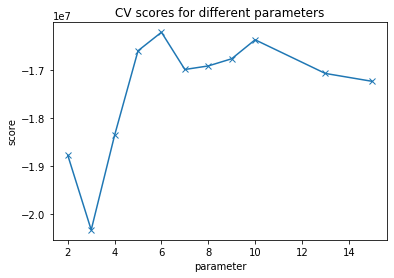

In [102]:
#using cross validation to find n_neighbors
neighbors = [2,3,4,5,6,7,8,9,10,13,15]
scores_cv = []
for n in neighbors:
    model = KNeighborsRegressor(n_neighbors=n)
    scores_cv.append(cross_val_score(model, train_X_pca, train_y['count_list_target'], cv=4, 
                                     scoring='neg_mean_squared_error').mean())

plt.plot(neighbors,scores_cv,'x-')
plt.title('CV scores for different parameters')
plt.xlabel('parameter')
plt.ylabel('score')

In [103]:
#knn after pca
model = KNeighborsRegressor(n_neighbors=6)
model.fit(train_X_pca, train_y['count_list_target'])
y_pred_train = model.predict(train_X_pca)
y_pred_test = model.predict(test_X_pca)

knn2_rst = {'r2_train': model.score(train_X_pca, train_y['count_list_target']),
             'r2_test':model.score(test_X_pca, test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_pca, train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
knn2_rst

{'r2_train': 0.4295777014816079,
 'r2_test': 0.3034342834930239,
 'mse_train': 8940962.758547008,
 'mse_test': 15052731.191666666,
 'cv_score': 16688303.140972221}

knn with features selected by Lasso performs the best. knn_rst

### 6.3 Tree

In [148]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []
model = DecisionTreeRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
clf.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [104]:
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=1, min_samples_split=10)
model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_list_no])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no])

tree_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
tree_rst

{'r2_train': 0.9431713433709403,
 'r2_test': -0.2801576603293663,
 'mse_train': 890748.6678876678,
 'mse_test': 27664107.90430839,
 'cv_score': 16174208.350848034}

In [105]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []
model = DecisionTreeRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
clf.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [106]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=3, min_samples_split=8)
model.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_list_no_rf])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no_rf])

tree1_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no_rf], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
tree1_rst

{'r2_train': 0.6460110972018455,
 'r2_test': -0.30090954188902264,
 'mse_train': 5548523.62026862,
 'mse_test': 28112554.45778685,
 'cv_score': 12912027.689698095}

In [107]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []
model = DecisionTreeRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_pca, train_y['count_list_target'])
clf.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [108]:
model = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=8)
model.fit(train_X_pca, train_y['count_list_target'])
y_pred_train = model.predict(train_X_pca)
y_pred_test = model.predict(test_X_pca)
tree2_rst = {'r2_train': model.score(train_X_pca, train_y['count_list_target']),
             'r2_test':model.score(test_X_pca, test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_pca, train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
tree2_rst

{'r2_train': 0.8623421017544632,
 'r2_test': 0.025988544613281706,
 'mse_train': 2157689.3905270654,
 'mse_test': 21048312.123459876,
 'cv_score': 14238575.107293209}

Tree models with features selected by random forest performs the best. tree1_rst

### 6.4 Bagging: Random Forest

In [165]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4], 'min_samples_leaf':[1,3,5,7], 
          'n_estimators':[5,10,20], 'min_samples_split':[2,4,6,8,10,15]}
scores_cv = []

model = RandomForestRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
clf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [109]:
model = RandomForestRegressor(n_estimators=10, max_depth=4, min_samples_leaf=1,min_samples_split=3)
y_pred_train = []
y_pred_test = []
for i in range(1000):
    model.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_list_no_rf]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_list_no_rf]))
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)

rf_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no_rf], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
rf_rst

{'r2_train': 0.8099081149251179,
 'r2_test': 0.49255902027269904,
 'mse_train': 1539557.7631275696,
 'mse_test': 14986952.59013332,
 'cv_score': 15165023.077311289}

In [167]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4], 'min_samples_leaf':[1,3,5,7], 
          'n_estimators':[5,10,20], 'min_samples_split':[2,4,6,8,10,15]}
scores_cv = []

model = RandomForestRegressor()
clf = GridSearchCV(model, params,cv=5,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
clf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [110]:
model = RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_leaf=1,min_samples_split=4)
y_pred_train = []
y_pred_test = []
for i in range(1000):
    model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_list_no]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_list_no]))
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)

rf1_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
rf1_rst

{'r2_train': 0.8556431976449427,
 'r2_test': 0.12478960901824665,
 'mse_train': 1851341.522750461,
 'mse_test': 18614393.87702511,
 'cv_score': 16733376.863047395}

Random forest with features selected by lasso performs the best. rf_rst

### 6.5 Boosting: GBDT

In [169]:
#use grid search to find the params
params = {'learning_rate':[0.1,0.3,0.5,1.],'max_depth':[2,3,4], 'min_samples_leaf':[4,6,8], 
          'min_samples_split':[5,10,15],'n_estimators':[5,10,20], 'subsample':[0.3,0.5,0.8,1.]}
scores_cv = []

model = GradientBoostingRegressor()
clf = GridSearchCV(model, params,cv=5, scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=5,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [111]:
model = GradientBoostingRegressor(learning_rate=1.0, n_estimators=5, subsample=1.0, 
                                  max_depth=3,min_samples_split=10, min_samples_leaf=4)
y_pred_train = []
y_pred_test = []
for i in range(500):
    model.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_list_no_rf]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_list_no_rf]))
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)

gbdt_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no_rf], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
gbdt_rst

{'r2_train': 0.9730858389218142,
 'r2_test': -0.3710022505940451,
 'mse_train': 421860.28229021723,
 'mse_test': 22614876.93464158,
 'cv_score': 14841107.506146157}

In [172]:
#use grid search to find the params
params = {'learning_rate':[0.1,0.3,0.5,1.],'max_depth':[2,3,4], 'min_samples_leaf':[4,6,8], 
          'min_samples_split':[5,10,15],'n_estimators':[5,10,20], 'subsample':[0.3,0.5,0.8,1.]}
scores_cv = []

model = GradientBoostingRegressor()
clf = GridSearchCV(model, params,cv=5, scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=15,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [114]:
model = GradientBoostingRegressor(learning_rate=1.0, n_estimators=10, subsample=0.8, 
                                  max_depth=4,min_samples_split=15, min_samples_leaf=4)
y_pred_train = []
y_pred_test = []
for i in range(1000):
    model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_list_no]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_list_no]))
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)

gbdt1_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no], train_y['count_list_target']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no], test_y['count_list_target']),
             'mse_train': mean_squared_error(train_y['count_list_target'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_target'],y_pred_test),
            'cv_score':-cross_val_score(model, train_X_std[:,selected_features_list_no], train_y['count_list_target'], cv=5,scoring='neg_mean_squared_error').mean()}
gbdt1_rst

{'r2_train': 0.9895988543174546,
 'r2_test': 0.4120178661408104,
 'mse_train': 22156.989402225,
 'mse_test': 16806979.78248314,
 'cv_score': 29502409.162553884}

GBDT with features selected by random forest performs the best. gbdt_rst

### 6.6 Comparison: models to predict the number of house listings in 3 month in Denver

In [116]:
result1 = pd.DataFrame(columns=['Lasso','Elastic','Ridge after Lasso','Regression after PCA','KNN', 'Tree','RandomForest','GBDT'])
for i,mod in enumerate([lasso_rst, elastic_rst,ridge1_rst,pcalr_rst, knn_rst,tree1_rst,rf_rst,gbdt_rst]):
    result1.iloc[:,i] = pd.Series(mod)
result1

,Lasso,Elastic,Ridge after Lasso,Regression after PCA,KNN,Tree,RandomForest,GBDT
r2_train,9.094962e-01,7.453712e-01,6.642899e-01,4.539825e-01,8.277218e-01,6.460111e-01,8.099081e-01,9.730858e-01
r2_test,4.386617e-01,4.079860e-01,3.262145e-01,-1.403561e+00,-1.416931e-02,-3.009095e-01,4.925590e-01,-3.710023e-01
mse_train,1.418582e+06,3.991124e+06,5.262016e+06,8.558435e+06,2.700338e+06,5.548524e+06,1.539558e+06,4.218603e+05
mse_test,1.213048e+07,1.279338e+07,1.456045e+07,5.194076e+07,2.191612e+07,2.811255e+07,1.498695e+07,2.261488e+07
cv_score,1.736894e+07,1.650854e+07,1.689477e+07,2.844030e+07,1.442152e+07,1.291203e+07,1.516502e+07,1.484111e+07


Text(0.5, 1.0, 'cross validation MSE for predicting listings')

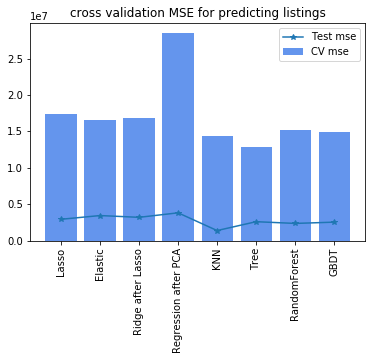

In [118]:
plt.bar(result1.columns, result1.loc['cv_score',:],color='cornflowerblue',label='CV mse')
plt.plot(result1.columns, result.loc['mse_test',:],'*-',label='Test mse')
plt.legend()
plt.xticks(rotation = 90)
plt.title('cross validation MSE for predicting listings')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text xticklabel objects>)

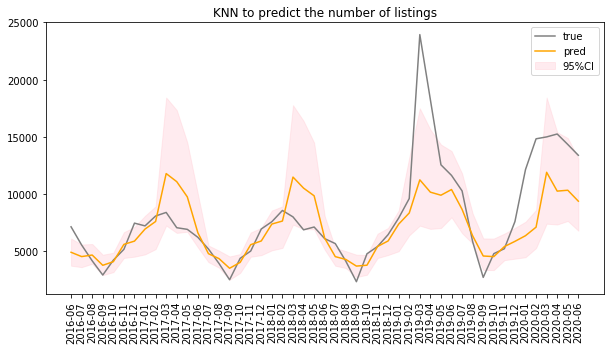

In [120]:
model = KNeighborsRegressor(n_neighbors=6)
#model.fit(train_X_pca, train_y['count_list_target'])
#y_pred_train = model.predict(train_X_pca)
#y_pred_test = model.predict(test_X_pca)
y_predict = []
for i in range(1000):
    indices = np.random.choice(np.arange(39),39, replace=True)   
    model.fit(train_X_pca[indices,:], train_y['count_list_target'].values[indices])
    predict = np.append(model.predict(train_X_pca),model.predict(test_X_pca))
    y_predict.append(predict)
    #plt.plot(monthData.month[3:52], np.append(model.predict(train_X_pca),model.predict(test_X_pca)),alpha=0.03,color='pink')

plt.figure(figsize=(10,5))
y_predict_mean = np.mean(np.array(y_predict),axis=0)
y_pred_upper = np.percentile(np.array(y_predict),97.5, axis=0)
y_pred_lower = np.percentile(np.array(y_predict),2.5, axis=0)

plt.plot(monthData.month[3:52], merged['count_list_target'], label='true',color='grey')
plt.plot(monthData.month[3:52], y_predict_mean, label='pred',color='orange')
plt.fill_between(monthData.month[3:52], y_pred_upper, y_pred_lower, color = 'pink',alpha=0.3,label='95%CI')
plt.legend()
plt.title('KNN to predict the number of listings')
plt.xticks(rotation=90)

In [197]:
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=4)
model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
y_predict = []
for i in range(1000):
    indices = np.random.choice(np.arange(39),39, replace=True)
    model.fit(train_X_std[:,selected_features_list_no][indices,:], train_y['count_list_target'].values[indices])
    predict = np.append(model.predict(train_X_std[:,selected_features_list_no]),model.predict(test_X_std[:,selected_features_list_no]))
    y_predict.append(predict)
    #plt.plot(monthData.month[3:52], np.append(model.predict(train_X_pca),model.predict(test_X_pca)),alpha=0.03,color='pink')



([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text xticklabel objects>)

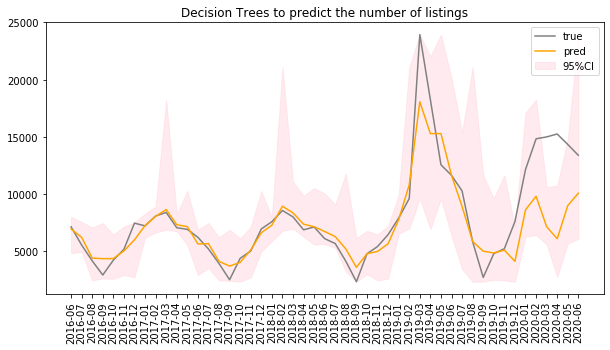

In [198]:
plt.figure(figsize=(10,5))
y_predict_mean = np.mean(np.array(y_predict),axis=0)
y_pred_upper = np.percentile(np.array(y_predict),97.5, axis=0)
y_pred_lower = np.percentile(np.array(y_predict),2.5, axis=0)

plt.plot(monthData.month[3:52], merged['count_list_target'], label='true',color='grey')
plt.plot(monthData.month[3:52], y_predict_mean, label='pred',color='orange')
plt.fill_between(monthData.month[3:52], y_pred_upper, y_pred_lower, color = 'pink',alpha=0.3,label='95%CI')
plt.legend()
plt.title('Decision Trees to predict the number of listings')
plt.xticks(rotation=90)

    For all models, Decision tree with features selected by feature importance in random forest performs the best. KNN is the K nearest neighbors model with features selected by Lasso regression, and it also performs better than others.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text xticklabel objects>)

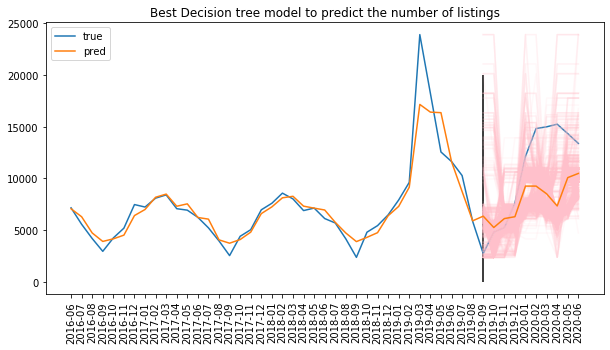

In [571]:
#decision tree -- plot
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=6)
y_pred_train = []
y_pred_test = []
plt.figure(figsize=(10,5))
plt.plot(monthData.month[3:52], merged['count_list_target'], label='true')
for i in range(1000):
    indices = np.random.choice(np.arange(39),39, replace=True)
    model.fit(train_X_std[indices,:][:,selected_features_list_no_rf], train_y['count_list_target'].values[indices])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_list_no_rf]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_list_no_rf]))
    plt.plot(monthData.month[42:52], model.predict(test_X_std[:,selected_features_list_no_rf]),alpha=0.1,color='pink')
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)
plt.plot(monthData.month[3:52], np.append(y_pred_train, y_pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=20000)
plt.title('Best Decision tree model to predict the number of listings')
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text xticklabel objects>)

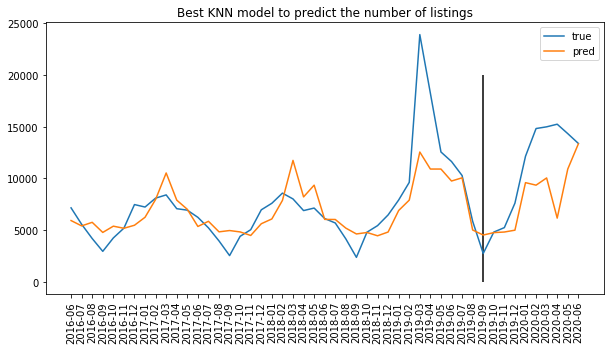

In [535]:
#knn -- plot
model = KNeighborsRegressor(n_neighbors=7)
model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_target'])
y_pred_train = model.predict(train_X_std[:,selected_features_list_no])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no])
plt.figure(figsize=(10,5))
plt.plot(monthData.month[3:52], merged['count_list_target'], label='true')
plt.plot(monthData.month[3:52], np.append(y_pred_train, y_pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=20000)
plt.title('Best KNN model to predict the number of listings')
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text xticklabel objects>)

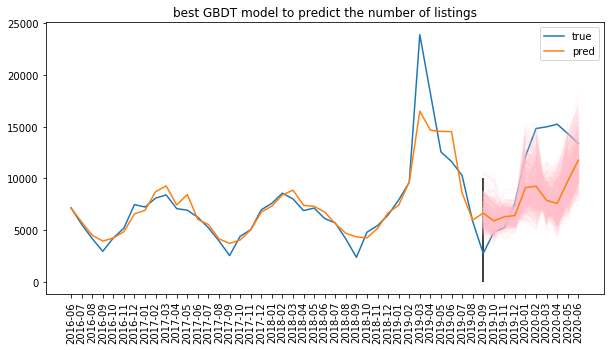

In [544]:
#gbdt -- plot
model = GradientBoostingRegressor(learning_rate=0.5, n_estimators=5, subsample=0.8, 
                                  max_depth=3,min_samples_split=5, min_samples_leaf=4)
y_pred_train = []
y_pred_test = []
plt.figure(figsize=(10,5))
plt.plot(monthData.month[3:52], merged['count_list_target'], label='true')
for i in range(500):
    model.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_list_no_rf]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_list_no_rf]))
    plt.plot(monthData.month[42:52], model.predict(test_X_std[:,selected_features_list_no_rf]), alpha=0.1, color='pink')
    
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)
plt.plot(monthData.month[3:52], np.append(y_pred_train, y_pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)
plt.title('best GBDT model to predict the number of listings')
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text xticklabel objects>)

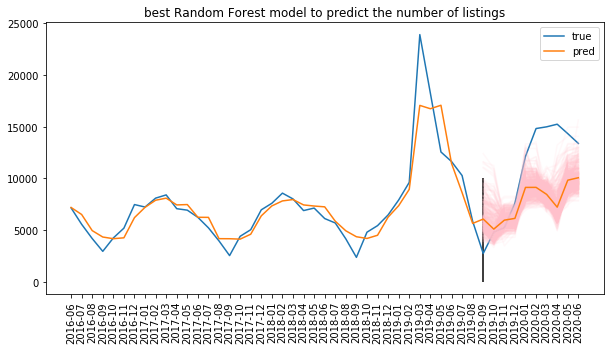

In [546]:
#random forest -- plot
model = RandomForestRegressor(n_estimators=5, max_depth=3, min_samples_leaf=1,min_samples_split=8)
y_pred_train = []
y_pred_test = []

plt.figure(figsize=(10,5))
plt.plot(monthData.month[3:52], merged['count_list_target'], label='true')
for i in range(500):
    model.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_target'])
    y_pred_train.append(model.predict(train_X_std[:,selected_features_list_no_rf]))
    y_pred_test.append(model.predict(test_X_std[:,selected_features_list_no_rf]))
    plt.plot(monthData.month[42:52], model.predict(test_X_std[:,selected_features_list_no_rf]), alpha=0.1, color='pink')
    
y_pred_train = np.mean(np.array(y_pred_train),axis=0)
y_pred_test = np.mean(np.array(y_pred_test),axis=0)
plt.plot(monthData.month[3:52], np.append(y_pred_train, y_pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)
plt.title('best Random Forest model to predict the number of listings')
plt.xticks(rotation=90)